In [1]:
import datetime
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers
from keras import models
from keras import regularizers
from keras import utils
from keras.utils import to_categorical
from tensorflow import keras

%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

# Parameters

In [3]:
# Embedding Tokens

# max_words = vocabulary size = our samples - number of most frequent words.
# I set it to 10.000, although in this case there are less.
# I do this to parametise the code.
# Aleternatively, I can set it to the length of our vocabulary = word_index
max_words = 10000

# embedding_size = embedding dimensionality
embedding_size = 10


# Training parameters
model_path = "product_descr_TF.h5"
epochs = 15
batch_size = 28

# For GloVe word-embeddings matrix (pre-trained model)
embedding_dim = 100

# Define Parameter Dictionary

This dictionary contains all the parameters necessary for the model training. It is going to be saved with the trained model in order to log it. 


Inputs before running a new experiment: 
1. Define experiment name
2. Define model architecture and hyperparameters

In [4]:
logging = True

saving = True

PARAMS = {

    # Define experiment name:
    'experiment_name': 'all_models',

    # List of models
    'models': ['baseline', 'bow', 'fc_emb', 'fc_transf', 'lstm', 'lstm_transf' 'conv1d', 'conv1d_transf'],

    # Parameters general:
    'n_splits': 4,
    'seed': 42,
    'batch_size': [16, 32, 64],
    'epochs': 15,
    'hidden_units': [16, 32, 64],
    'embedding_size': [10, 20, 30, 100],

    # Parameters for pre-trained word embeddings:
    'embedding_dim': 100,

    # Parameters for the Conv1D:
    'conv_window': [3, 5, 7],
}

logdir = f'logs/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")
logdir_tb = f'logs/tensorboard/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")

# create logging folder and tensorboard callback function
if logging:
    print(f'Log results to{logdir}')
    if not os.path.exists(logdir):
        os.makedirs(logdir)

    tensorboard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir_tb)]

else:
    logdir = ''
    lgdir_tb = ''
    tensorboard_callbacks = []

Log results tologs/experiments/all_models_2020_12_02-10:44


# Load Tokens and Vocabulary

In [5]:
def load_data(path_to_corpus, one_hot=False):
    if not one_hot:
        sequences, word_index = pd.read_pickle(path_to_corpus)
        
        # max_len = sequence length - the text is cut off after this number of words
        # in this case it is defined as the maximum sequence length in our list of tokenised sequences
        max_len = np.max([len(x) for x in sequences])
        data = tf.keras.preprocessing.sequence.pad_sequences(
            sequences, maxlen=max_len)
    else:
        sequences, word_index = pd.read_pickle(path_to_corpus)
        data = sequences

    labels = train_descr.loc[:, 'Sentiment'].to_list()

    return sequences, word_index, data, labels

for bag-of-words with one-hot encoded tokens

In [6]:
sequences_oh, word_index_oh, data_oh, labels_oh = load_data(
    preprocessed_corpus_path_TF_oh, one_hot=True)
sequences_oh.shape

(6364, 10000)

for the models with embedding layer

In [7]:
sequences, word_index, data, labels = load_data(preprocessed_corpus_path_TF)
print(f'Shape of sequences after padding is {data.shape}')

Shape of sequences after padding is (6364, 25)


# Preparation for the Pre-Trained Embeddings

In [8]:
glove_dir = './glove.6B'

In [9]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_matrix = np.zeros((max_words+1, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


# Oversample the Minority Classes

In [11]:
def oversample_smote(data, labels):
    oversample = SMOTE()
    data, labels = oversample.fit_resample(data, labels)

    counter = Counter(labels)
    for k, v in counter.items():
        per = v / len(labels) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()

    return data, labels

for bag-of-words with one-hot encoded tokens

Class=2, n=3765 (25.000%)
Class=1, n=3765 (25.000%)
Class=3, n=3765 (25.000%)
Class=0, n=3765 (25.000%)


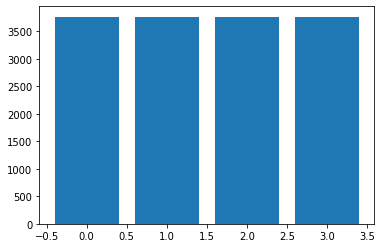

In [12]:
data_oh_ovs, labels_oh_ovs = oversample_smote(data_oh, labels_oh)

for the models with embedding layer

Class=2, n=3765 (25.000%)
Class=1, n=3765 (25.000%)
Class=3, n=3765 (25.000%)
Class=0, n=3765 (25.000%)


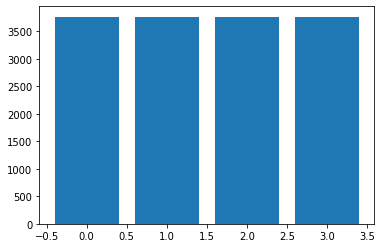

In [13]:
data_ovs, labels_ovs = oversample_smote(data, labels)

# Generate Train and Validation Data

In [14]:
def train_val_data(data_ovs, lables_ovs, one_hot=False):
    dimensions_labels = len(np.unique(labels_ovs))
    labels_encoded = tf.one_hot(indices=labels_ovs, depth=dimensions_labels)
    labels_encoded = np.asarray(labels_encoded)

    indices = np.arange(data_ovs.shape[0])
    np.random.shuffle(indices)

    data_ovs = data_ovs[indices]
    labels_encoded = labels_encoded[indices]

    training_samples = int(0.8 * len(data_ovs))

    x_train = data_ovs[:training_samples]
    y_train = labels_encoded[:training_samples]

    x_val = data_ovs[training_samples:]
    y_val = labels_encoded[training_samples:]

    return x_train, y_train, x_val, y_val

In [15]:
x_train_oh, y_train_oh, x_val_oh, y_val_oh = train_val_data(
    data_oh_ovs, labels_oh_ovs)

In [16]:
x_train, y_train, x_val, y_val = train_val_data(data_ovs, labels_ovs)

# Generate Model

In [17]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [20]:
def generate_model(model, hidden_units, embedding_size=None, conv_window=None):
    # baseline model
    if model == PARAMS['models'][0]:
        model = DummyClassifier(strategy='most_frequent')

    # fully connected bag-of-words
    elif model == PARAMS['models'][1]:
        model.add(layers.Dense(hidden_units, activation='relu',
                               input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & "homegrown" embeddings layer
    elif model == PARAMS['models'][1]:
        model = models.Sequential()

        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu',
                               input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & a pre-trained embeddings layer
    elif model == PARAMS['models'][2]:
        model = models.Sequential()

        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu',
                               input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    # lstm with "homegrowm" embeddings layer
    elif model == PARAMS['models'][3]:
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # lstm with pre-trained embeddings layer
    elif model == PARAMS['models'][4]:
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model_lstm.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model_lstm.layers[0].trainable = False

    # conv1D with "homegrown" embeddings layer
    elif model == PARAMS['models'][5]:

        model = models.Sequential()

        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))

        model.add(layers.Conv1D(
            hidden_units,  # features to be extracted
            conv_window,  # convolutional window size
            activation='relu',
        ))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # conv1D with pre-trained embeddings layer
    elif model == PARAMS['models'][6]:

        model = models.Sequential()

        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))

        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu',))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model